# Word-level Seq2Seq (encoder-decoder) model with teacher forcing

Ref: https://wikidocs.net/86900

This is similar to the project1 but slightly different by using Teacher forcing.

Previous Model and this model does not use attention mechnism. 

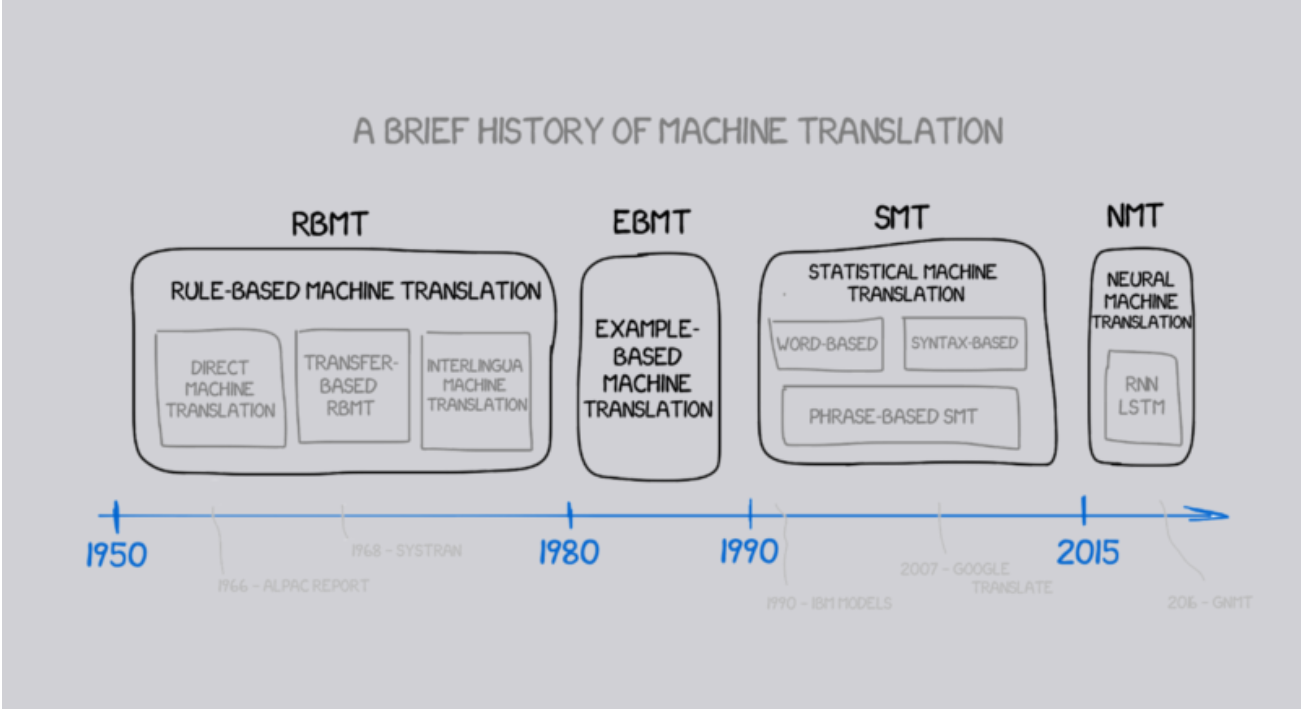

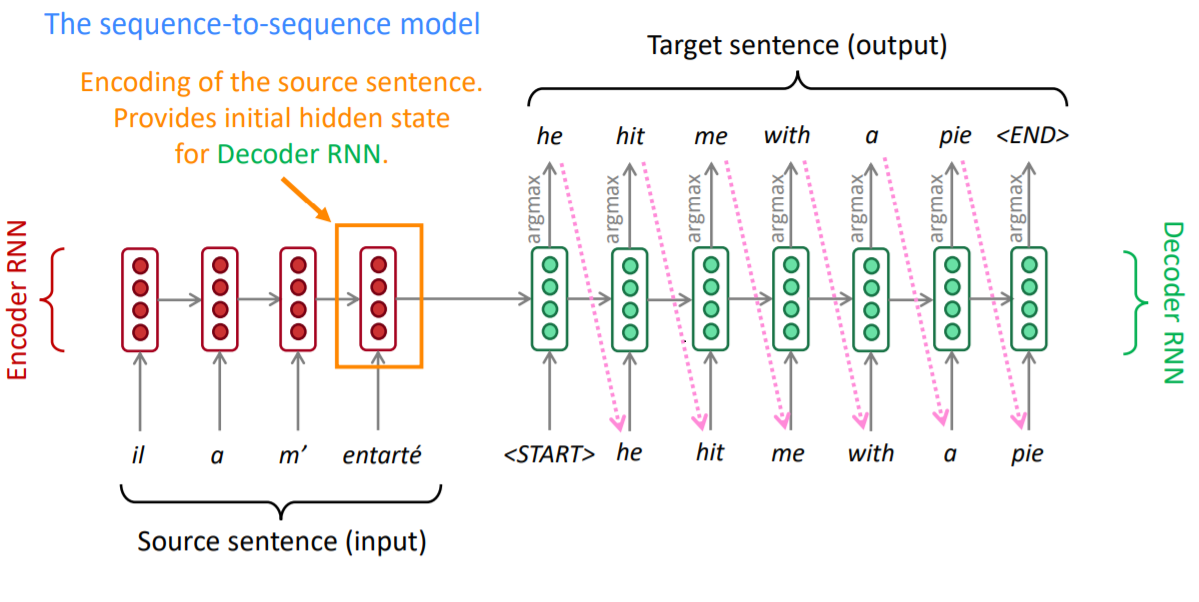

In [1]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [23]:
Option_training = True
Option_evaluation = False
Option_examples = True

## preprocessing

Original example is for Frech-English, But we will use German-English.

In [74]:
num_samples = 50000

corpus_file = 'deu2.txt'

def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
  # 악센트 제거 함수 호출
  sent = to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백 추가.
  # ex) "I am a student." => "I am a student ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open(corpus_file, "r",encoding='UTF8') as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      #src_line, tar_line, _ = line.strip().split('\t')
      tar_line, src_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break

  return encoder_input, decoder_input, decoder_target

def load_clean_sentences(filename):
    import pickle
    return pickle.load(open(filename, 'rb'))

In [61]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
if Option_examples:
    print('인코더의 입력 :',sents_en_in[:5])
    print('디코더의 입력 :',sents_fra_in[:5])
    print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['geh', '.'], ['hallo', '!'], ['gru', 'gott', '!'], ['lauf', '!'], ['lauf', '!']]
디코더의 입력 : [['<sos>', 'go', '.'], ['<sos>', 'hi', '.'], ['<sos>', 'hi', '.'], ['<sos>', 'run', '!'], ['<sos>', 'run', '.']]
디코더의 레이블 : [['go', '.', '<eos>'], ['hi', '.', '<eos>'], ['hi', '.', '<eos>'], ['run', '!', '<eos>'], ['run', '.', '<eos>']]


In [65]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")
encoder_input_length = encoder_input.shape[1]

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [6]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (50000, 17)
디코더의 입력의 크기(shape) : (50000, 9)
디코더의 레이블의 크기(shape) : (50000, 9)


In [7]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 9723, 프랑스어 단어 집합의 크기 : 5922


In [8]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

### Randomize data

Note that vocabulary is not randomized!

In [9]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 2011 43695 25795 ... 22901  1193  3416]


In [10]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [11]:
if Option_examples:
    encoder_input[30997]

In [12]:
if Option_examples:
    decoder_input[30997]

In [13]:
if Option_examples:
    decoder_target[30997]

In [14]:
n_of_val = 5000 # test data set 
print('검증 데이터의 개수 :',n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

검증 데이터의 개수 : 5000
훈련 source 데이터의 크기 : (45000, 17)
훈련 target 데이터의 크기 : (45000, 9)
훈련 target 레이블의 크기 : (45000, 9)
테스트 source 데이터의 크기 : (5000, 17)
테스트 target 데이터의 크기 : (5000, 9)
테스트 target 레이블의 크기 : (5000, 9)


## Make model

In [15]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

embedding_dim = 64
hidden_units = 64

# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

## Train Model

In [16]:
if Option_training :
    model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=64, epochs=50)

Epoch 1/50
704/704 [==============================] - 58s 72ms/step - loss: 3.2579 - acc: 0.4772 - val_loss: 2.5104 - val_acc: 0.6000
Epoch 2/50
704/704 [==============================] - 48s 69ms/step - loss: 2.2793 - acc: 0.6302 - val_loss: 2.0851 - val_acc: 0.6608
Epoch 3/50
704/704 [==============================] - 49s 70ms/step - loss: 1.9115 - acc: 0.6850 - val_loss: 1.8284 - val_acc: 0.6981
Epoch 4/50
704/704 [==============================] - 48s 68ms/step - loss: 1.7022 - acc: 0.7109 - val_loss: 1.6781 - val_acc: 0.7176
Epoch 5/50
704/704 [==============================] - 49s 69ms/step - loss: 1.5507 - acc: 0.7302 - val_loss: 1.5623 - val_acc: 0.7336
Epoch 6/50
704/704 [==============================] - 47s 67ms/step - loss: 1.4263 - acc: 0.7472 - val_loss: 1.4707 - val_acc: 0.7472
Epoch 7/50
704/704 [==============================] - 47s 66ms/step - loss: 1.3173 - acc: 0.7616 - val_loss: 1.3916 - val_acc: 0.7580
Epoch 8/50
704/704 [==============================] - 48s 69ms

## Redefine model for the test 

seq2seq는 훈련 과정(교사 강요)과 테스트 과정에서의 동작 방식이 다릅니다. 그래서 테스트 과정을 위해 모델을 다시 설계해주어야 합니다. 특히 디코더를 수정해야 합니다. 이번에는 번역 단계를 위해 모델을 수정하고 동작시켜보겠습니다.

전체적인 번역 단계를 정리하면 아래와 같습니다.

번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [17]:
if Option_training:
    # 인코더
    encoder_model = Model(encoder_inputs, encoder_states)

    # 디코더 설계 시작
    # 이전 시점의 상태를 보관할 텐서
    decoder_state_input_h = Input(shape=(hidden_units,))
    decoder_state_input_c = Input(shape=(hidden_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    # 훈련 때 사용했던 임베딩 층을 재사용
    dec_emb2 = dec_emb_layer(decoder_inputs)

    # 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
    decoder_states2 = [state_h2, state_c2]

    # 모든 시점에 대해서 단어 예측
    decoder_outputs2 = decoder_dense(decoder_outputs2)

    # 수정된 디코더
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs2] + decoder_states2)
    #---save encoder and decoder model 

    encoder_model.save('encoder_model.h5')
    decoder_model.save('decoder_model.h5')

### reload encoder and decoder models and make a complete input-output steps.

In [19]:
#--reload model 
#encoder_model = keras.models.load_model('encoder_model.h5')
#decoder_model = keras.models.load_model('decoder_model.h5')

def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [26]:
if Option_examples:
    print("train 셋의 경우")
    for seq_index in [3, 50, 100, 300, 1001]:
      input_seq = encoder_input_train[seq_index: seq_index + 1]
      decoded_sentence = decode_sequence(input_seq)

      print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
      print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
      print("번역문장 :",decoded_sentence[1:-5])
      print("-"*50)

train 셋의 경우
1/1 [==============================] - 0s 14ms/step
입력문장 : sag mal bist du noch zu retten ? 
정답문장 : have you gone nuts ? 
번역문장 : have you gone nuts ? 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : tom ist sehr weise . 
정답문장 : tom is very wise . 
번역문장 : tom is very wise . 
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : wir haben spa hier . 
정답문장 : we have fun here . 
번역문장 : we ll be nice . 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : setz dich jetzt ! 
정답문장 : sit down now . 
번역문장 : sit down now . 
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : ich kann wahrscheinlich gewinnen . 
정답문장 : i can probably win . 
번역문장 : i can probably win . 
--------------------------------------------------


In [24]:
if Option_examples:
    print("테스트 셋의 경우")
    for seq_index in [3, 50, 100, 300, 1001]:
      input_seq = encoder_input_test[seq_index: seq_index + 1]
      decoded_sentence = decode_sequence(input_seq)

      print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
      print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
      print("번역문장 :",decoded_sentence[1:-5])
      print("-"*50)

테스트 셋의 경우
1/1 [==============================] - 0s 14ms/step
입력문장 : welcher hut ist deiner ? 
정답문장 : which hat is yours ? 
번역문장 : which hat is yours ? 
--------------------------------------------------
1/1 [==============================] - 0s 14ms/step
입력문장 : moment mal ! 
정답문장 : hold on there . 
번역문장 : wait a sec . 
--------------------------------------------------
1/1 [==============================] - 0s 14ms/step
입력문장 : wie alt ist er ? 
정답문장 : what is his age ? 
번역문장 : how old is he ? 
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : es ist einer von meinen . 
정답문장 : it s one of mine . 
번역문장 : it s one of mine . 
--------------------------------------------------
1/1 [==============================] - 0s 15ms/step
입력문장 : der schalter ist an . 
정답문장 : the switch is on . 
번역문장 : the one s close . 
--------------------------------------------------


In [66]:
def translate_german_sentence(src_line):
    # for text-> text translation 
    _input = []
    src_line = [w for w in preprocess_sentence(src_line).split()]
    _input.append(src_line)
    _input = tokenizer_en.texts_to_sequences(_input) #vectorized  
    input_seq = pad_sequences(_input, maxlen=encoder_input_length, padding="post") #padding 
    decoded_sentence = decode_sequence(input_seq) 
    return decoded_sentence 

In [71]:
translate_german_sentence('Ich liebe dich .')

1/1 [==============================] - 0s 17ms/step


' i love you . <eos>'

In [72]:
translate_german_sentence('Ich liebe dich ')

1/1 [==============================] - 0s 15ms/step


' i love you guys . <eos>'